# Secure FL – Iterative Multi‑Round Training
This notebook demonstrates multiple communication rounds using the secure protocol. In each round, a random subset of clients participates and a new closed‑form solution is computed, emulating asynchronous FL.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(0)


In [ ]:
def add_intercept(X): return np.hstack([np.ones((X.shape[0],1)), X])

def generate_synthetic_clients(n_clients=10, n_features=7, seed=0):
    rng = np.random.default_rng(seed)

    w_true = rng.normal(size=n_features)
    clients = []
    for i in range(n_clients):
        m = rng.integers(1000,2000)

        X = rng.normal(loc=i*3.0, scale=1.0, size=(m,n_features))
        y = X @ w_true + rng.normal(scale=1.0, size=m)

        idx = rng.permutation(m)

        split = int(0.9*m)
        clients.append({
            "X_train": add_intercept(X[idx[:split]]),
            "y_train": y[idx[:split]],
            "X_test":  add_intercept(X[idx[split:]]),
            "y_test":  y[idx[split:]]
        })
    return clients

def secure_protocol_single_round(clients, beta_range=(-0.1,0.1), seed=0):
    rng = np.random.default_rng(seed)

    n = clients[0]["X_train"].shape[1] - 1

    while True:
        W = rng.normal(size=(n+2,n+2)); W[-1,:] = 1.0
        if np.linalg.matrix_rank(W) == n+2: break

    L_sum = np.zeros((n+1,n+2))
    for c in clients:
        X = c["X_train"]; y=c["y_train"]
        Y = np.tile(y.reshape(-1,1), (1,n+2))       # hstack the n+2 copies of y

        L = X.T @ (X @ W[:-1,:] - Y)

        beta = rng.uniform(*beta_range)
        L_sum += (1-beta)*L

    C = L_sum @ np.linalg.inv(W)
    A, b = C[:,:-1], C[:,-1]

    return -np.linalg.solve(A,b)

def evaluate(w, clients):
    X = np.vstack([c["X_test"] for c in clients])
    y = np.hstack([c["y_test"] for c in clients])

    return mean_squared_error(y, X@w)

In [ ]:
clients = generate_synthetic_clients()
n_rounds = 8
participation_rate = 0.6
rng = np.random.default_rng(0)
history_mse = []

w_global = np.zeros(clients[0]["X_train"].shape[1])  # init (never used but kept for completeness)

for r in range(n_rounds):
    subset_idx = rng.choice(len(clients), size=int(participation_rate*len(clients)), replace=False)
    subset = [clients[i] for i in subset_idx]

    w_global = secure_protocol_single_round(subset, seed=r)

    mse = evaluate(w_global, clients)
    history_mse.append(mse)

    print(f"Round {r+1}: MSE(global test) = {mse:.3f}")


Round 1: MSE(global test) = 1.027
Round 2: MSE(global test) = 1.028
Round 3: MSE(global test) = 1.028
Round 4: MSE(global test) = 1.029
Round 5: MSE(global test) = 1.027
Round 6: MSE(global test) = 1.026
Round 7: MSE(global test) = 1.028
Round 8: MSE(global test) = 1.027


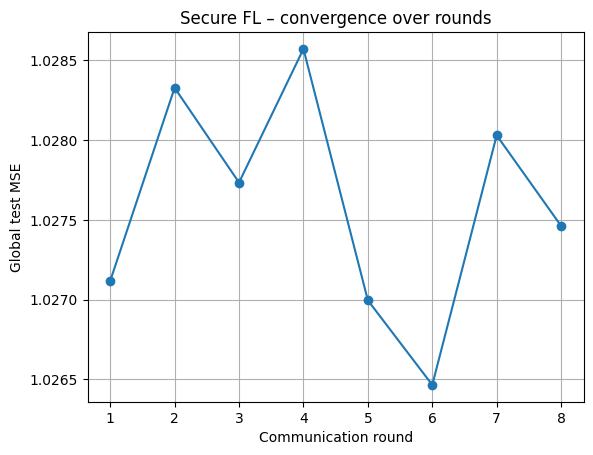

In [ ]:
plt.figure()
plt.plot(range(1, len(history_mse)+1), history_mse, marker='o')
plt.xlabel('Communication round')
plt.ylabel('Global test MSE')
plt.title('Secure FL – convergence over rounds')
plt.grid(True)
plt.show()
